In [1]:
%matplotlib inline 

from __future__ import division

import sys
if '../' not in sys.path: sys.path.append("../")

import numpy as np
import amnet
import control 

import matplotlib
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

In [2]:
def make_vgc(alpha):
    # inputs
    e_var = amnet.Variable(1, name='e')
    edot_var = amnet.Variable(1, name='edot')
    x = amnet.stack(e_var, edot_var)

    # affine transformations
    zero1 = amnet.atoms.make_const(np.zeros(1), x)
    ae    = amnet.AffineTransformation(np.array([[alpha, 0]]), x, np.zeros(1))
    e     = amnet.AffineTransformation(np.array([[1, 0]]), x, np.zeros(1))
    neg_e = amnet.AffineTransformation(np.array([[-1, 0]]), x, np.zeros(1))
    edot  = amnet.AffineTransformation(np.array([[0, 1]]), x, np.zeros(1))
    neg_edot = amnet.AffineTransformation(np.array([[0, -1]]), x, np.zeros(1))

    return amnet.atoms.make_or(
        amnet.atoms.make_or(
            zero1,
            ae,
            neg_e,
            neg_edot
        ),
        ae,
        e,
        edot
    )


def true_vgc(e, edot, alpha):
    if e * edot > 0:
        return alpha * e
    else:
        return 0


def test_vgc():
    alpha = 1.1
    phi_vgc = make_vgc(alpha)

    # test that true_vgc and test_vgc return the same evaluation
    for e in np.linspace(-2,2,12):
        for edot in np.linspace(-2,2,12):
            val1 = phi_vgc.eval(np.array([e, edot]))
            val2 = true_vgc(e, edot, alpha)
            if abs(val1 - val2) > 1e-10:
                print 'FAIL: (e,edot) = (%e, %e), val1=%e, val2=%e' % (e, edot, val1, val2)

test_vgc()

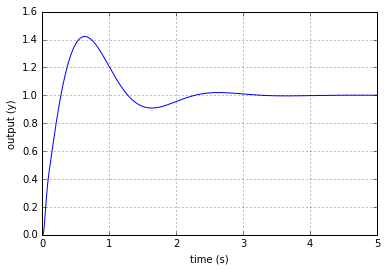

In [3]:
# plant transfer function
p = 1.0
P_tf = control.tf([0.05, 1.0], [1.0, -p]) * (control.tf([1], [0.01, 1.0]) ** 2)

# linear controller transfer function
k_p = 4.0
f_lp = 10.0
beta_lp = 0.7
f_i = 0.5
C_tf = k_p * control.tf([1.0, 2.0*np.pi*f_i], [1.0, 0.0]) * control.tf([1.0], [1.0/(2*np.pi*f_lp)**2, (2.0*beta_lp)/(2*np.pi*f_lp), 1.0])

# plot closed loop response
P_yr = control.feedback(P_tf * C_tf, 1)
ts = np.linspace(0, 5, 10000)
_, ys = control.step_response(P_yr, T=ts)
plt.plot(ts, ys)
plt.xlabel('time (s)')
plt.ylabel('output (y)')
plt.grid(True)

0.169094768275


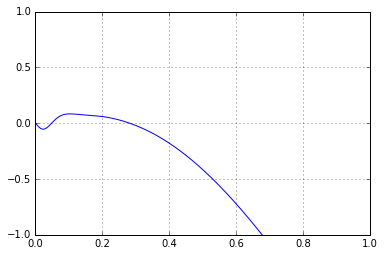

In [4]:
# compute rise time and overshoot minimum
sfun = interp1d(ts, ys, kind='cubic')
tr = 0.23 # computed by me
#tr = 0.28 # Hunnekens, et al. (2016)
plt.plot(ts, sfun(ts)-ts/tr)
plt.grid(True)
axes = plt.gca()
axes.set_ylim([-1.0, 1.0])
axes.set_xlim([0., 1.])

yos_min = ((p*tr - 1.)*np.exp(p*tr) + 1.)/(p*tr)
print yos_min

In [5]:
# convert loop transfer function to discrete time
dt = 0.001
A, B, C, D = control.ssdata(control.sample_system(P_tf * C_tf, Ts=dt, method='zoh'))
n,m = B.shape
assert m == 1
assert D == 0
print n

6
